### Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import sys
import datetime
from datetime import date, timedelta
from tqdm.notebook import tqdm
torch.manual_seed(0)
# sys.path.insert(0, '../models')
# from krs_inflow_model import SimpleMLP

### Read Datasets

In [2]:
inflow_df = pd.read_csv('../../dataset/reservoir_dataset_engg.csv')
inflow_df = inflow_df[inflow_df['RESERVOIR'] == 'K.R.S']
print(inflow_df.shape)
inflow_df.head()

(3274, 10)


,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,SEASON
0,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0,WINTER
1,K.R.S,46.54,122.68,3084.0,1490.0,2011,1,2,1,WINTER
2,K.R.S,46.64,122.75,2776.0,1491.0,2011,1,3,2,WINTER
3,K.R.S,46.69,122.79,2311.0,1491.0,2011,1,4,3,WINTER
4,K.R.S,46.70,122.80,1847.0,1491.0,2011,1,5,4,WINTER


In [3]:
weather_df = pd.read_csv('../../dataset/Weather/mysuru_kodagu_hassan_weather.csv')
print(weather_df.shape)
weather_df.head()

(12783, 35)


,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,heavy intensity drizzle,very heavy rain,thunderstorm with heavy rain,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm
0,2010-01-01,Hassan,21.77,22.02,17.22,26.35,1013.50,77.92,2.81,89.33,...,0,0,0,0,0,0,0,0,0,0
1,2010-01-01,Kodagu,23.90,24.71,20.06,31.39,1012.17,83.50,1.55,104.21,...,0,0,0,0,0,0,0,0,0,0
2,2010-01-01,Mysuru,24.18,24.51,18.82,30.30,1012.92,68.42,2.62,90.38,...,0,0,0,0,0,0,0,0,0,0
3,2010-01-02,Hassan,20.73,20.80,14.47,27.35,1015.25,73.75,2.42,70.29,...,0,0,0,0,0,0,0,0,0,0
4,2010-01-02,Kodagu,23.56,24.41,19.18,31.88,1014.08,78.38,1.41,112.46,...,0,0,0,0,0,0,0,0,0,0


In [4]:
weather_df['YYYY'] = weather_df['date'].str[:4].astype(int)
weather_df['MM'] = weather_df['date'].str[5:7].astype(int)
weather_df['DD'] = weather_df['date'].str[8:].astype(int)
weather_df

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,...,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm,YYYY,MM,DD
0,2010-01-01,Hassan,21.77,22.02,17.22,26.35,1013.50,77.92,2.81,89.33,...,0,0,0,0,0,0,0,2010,1,1
1,2010-01-01,Kodagu,23.90,24.71,20.06,31.39,1012.17,83.50,1.55,104.21,...,0,0,0,0,0,0,0,2010,1,1
2,2010-01-01,Mysuru,24.18,24.51,18.82,30.30,1012.92,68.42,2.62,90.38,...,0,0,0,0,0,0,0,2010,1,1
3,2010-01-02,Hassan,20.73,20.80,14.47,27.35,1015.25,73.75,2.42,70.29,...,0,0,0,0,0,0,0,2010,1,2
4,2010-01-02,Kodagu,23.56,24.41,19.18,31.88,1014.08,78.38,1.41,112.46,...,0,0,0,0,0,0,0,2010,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12778,2021-08-30,Kodagu,20.07,20.57,19.03,23.77,1009.00,93.50,1.71,241.83,...,0,0,0,0,0,0,0,2021,8,30
12779,2021-08-30,Mysuru,22.36,22.90,19.59,28.21,1009.33,82.33,5.38,253.62,...,0,0,0,0,0,0,0,2021,8,30
12780,2021-08-31,Hassan,21.86,22.21,18.87,26.31,1009.29,82.17,3.39,249.33,...,0,0,0,0,0,0,0,2021,8,31
12781,2021-08-31,Kodagu,21.29,21.81,19.03,26.23,1009.79,89.21,1.78,245.88,...,0,0,0,0,0,0,0,2021,8,31


In [5]:
kodagu_df = weather_df[weather_df['city_name'] == 'Kodagu'].reset_index(drop=True)
hassan_df = weather_df[weather_df['city_name'] == 'Hassan'].reset_index(drop=True)
mysuru_df = weather_df[weather_df['city_name'] == 'Mysuru'].reset_index(drop=True)

print(kodagu_df.shape, hassan_df.shape, mysuru_df.shape)

(4261, 38) (4261, 38) (4261, 38)


### Dataset Transformation

In [6]:
inflow_df = inflow_df[['INFLOW_CUSECS', 'YEAR', 'MONTH', 'DATE', 'SEASON']]
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE,SEASON
0,2029.0,2011,1,1,WINTER
1,3084.0,2011,1,2,WINTER
2,2776.0,2011,1,3,WINTER
3,2311.0,2011,1,4,WINTER
4,1847.0,2011,1,5,WINTER


In [7]:
month_le = LabelEncoder().fit(inflow_df['MONTH'].unique())
date_le = LabelEncoder().fit(inflow_df['DATE'].unique())
season_le = LabelEncoder().fit(inflow_df['SEASON'].unique())

In [8]:
rs_inflow = RobustScaler().fit(inflow_df[['INFLOW_CUSECS']])
rs_temp = RobustScaler().fit(weather_df[['temp']])
rs_feels_like = RobustScaler().fit(weather_df[['feels_like']])
rs_temp_min = RobustScaler().fit(weather_df[['temp_min']])
rs_temp_max = RobustScaler().fit(weather_df[['temp_max']])
rs_pressure = RobustScaler().fit(weather_df[['pressure']])
rs_humidity = RobustScaler().fit(weather_df[['humidity']])
rs_wind_speed = RobustScaler().fit(weather_df[['wind_speed']])
rs_wind_deg = RobustScaler().fit(weather_df[['wind_deg']])
rs_rain = RobustScaler().fit(weather_df[['rain']])
rs_clouds_all = RobustScaler().fit(weather_df[['clouds_all']])
# remaining columns will be divided by 24 for scaling purpose.

In [10]:
inflow_df['INFLOW_CUSECS'] = rs_inflow.transform(inflow_df[['INFLOW_CUSECS']]).flatten()
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE,SEASON
0,0.073551,2011,1,1,WINTER
1,0.289397,2011,1,2,WINTER
2,0.226382,2011,1,3,WINTER
3,0.131246,2011,1,4,WINTER
4,0.036315,2011,1,5,WINTER


In [11]:
weather_df.columns

Index(['date', 'city_name', 'temp', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain', 'clouds_all',
       'broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm',
       'YYYY', 'MM', 'DD'],
      dtype='object')

In [12]:
weather_df['temp'] = rs_temp.transform(weather_df[['temp']]).flatten()
weather_df['feels_like'] = rs_feels_like.transform(weather_df[['feels_like']]).flatten()
weather_df['temp_min'] = rs_temp_min.transform(weather_df[['temp_min']]).flatten()
weather_df['temp_max'] = rs_temp_max.transform(weather_df[['temp_max']]).flatten()
weather_df['pressure'] = rs_pressure.transform(weather_df[['pressure']]).flatten()
weather_df['humidity'] = rs_humidity.transform(weather_df[['humidity']]).flatten()
weather_df['wind_speed'] = rs_wind_speed.transform(weather_df[['wind_speed']]).flatten()
weather_df['wind_deg'] = rs_wind_deg.transform(weather_df[['wind_deg']]).flatten()
weather_df['rain'] = rs_rain.transform(weather_df[['rain']]).flatten()
weather_df['clouds_all'] = rs_clouds_all.transform(weather_df[['clouds_all']]).flatten()
weather_df.loc[:, ('broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm')] = weather_df.loc[:, ('broken clouds', 'overcast clouds', 'scattered clouds', 'sky is clear',
       'few clouds', 'fog', 'light rain', 'mist', 'haze', 'moderate rain',
       'heavy intensity rain', 'light intensity drizzle', 'drizzle',
       'heavy intensity drizzle', 'very heavy rain',
       'thunderstorm with heavy rain', 'thunderstorm with rain',
       'thunderstorm', 'proximity shower rain', 'thunderstorm with light rain',
       'shower rain', 'light intensity shower rain', 'light thunderstorm')] / 24

In [13]:
weather_df.head()

,date,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain,clouds_all,broken clouds,overcast clouds,scattered clouds,sky is clear,few clouds,fog,light rain,mist,haze,moderate rain,heavy intensity rain,light intensity drizzle,drizzle,heavy intensity drizzle,very heavy rain,thunderstorm with heavy rain,thunderstorm with rain,thunderstorm,proximity shower rain,thunderstorm with light rain,shower rain,light intensity shower rain,light thunderstorm,YYYY,MM,DD
0,2010-01-01,Hassan,-0.736,-0.737201,-1.281690,-0.657143,0.683274,-0.156784,0.559748,-0.826564,-0.116022,-0.149059,0.208333,0.500000,0.166667,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
1,2010-01-01,Kodagu,0.116,0.180887,-0.281690,0.242857,0.209964,0.161345,-0.232704,-0.714651,0.057090,-0.473641,0.125000,0.166667,0.333333,0.000000,0.250000,0.083333,0.041667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
2,2010-01-01,Mysuru,0.228,0.112628,-0.718310,0.048214,0.476868,-0.698404,0.440252,-0.818667,-0.116022,-0.894149,0.208333,0.000000,0.333333,0.166667,0.291667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,1
3,2010-01-02,Hassan,-1.152,-1.153584,-2.250000,-0.478571,1.306050,-0.394527,0.314465,-0.969765,-0.116022,-1.303287,0.083333,0.000000,0.125000,0.791667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,2
4,2010-01-02,Kodagu,-0.020,0.078498,-0.591549,0.330357,0.889680,-0.130559,-0.320755,-0.652602,-0.116022,-1.076700,0.125000,0.000000,0.125000,0.541667,0.125000,0.000000,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1,2


In [14]:
kodagu_df = weather_df[weather_df['city_name'] == 'Kodagu'].reset_index(drop=True)
hassan_df = weather_df[weather_df['city_name'] == 'Hassan'].reset_index(drop=True)
mysuru_df = weather_df[weather_df['city_name'] == 'Mysuru'].reset_index(drop=True)

In [15]:
train_inflow_df = inflow_df[inflow_df['YEAR'] < 2020].reset_index(drop=True)
val_inflow_df = inflow_df[inflow_df['YEAR'] == 2020].reset_index(drop=True)

train_inflow_df.shape, val_inflow_df.shape

((2944, 5), (330, 5))

In [16]:
def embed_day(df):
    data = {}
    for index in tqdm(df.index):
        row = df.iloc[index]
        inflow = row['INFLOW_CUSECS']
        year = row['YEAR']
        month = row['MONTH']
        date = row['DATE']
        season = row['SEASON']

        ddmmyyyy = datetime.date(year, month, date)
        ddmmyyyy_list = [str(ddmmyyyy + timedelta(days=day)) for day in range(-10, 2)]

        sel_kodagu = kodagu_df[kodagu_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        sel_hassan = hassan_df[hassan_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        sel_mysuru = mysuru_df[mysuru_df['date'].isin(ddmmyyyy_list)].drop(columns=['date', 'city_name', 'YYYY', 'MM', 'DD']).values.flatten()
        
        month_transformed = month_le.transform([month])
        date_transformed = date_le.transform([date])
        season_transformed = season_le.transform([season])
        # month_transformed = month_oe.transform([[month]]).toarray().flatten()
        # date_transformed = date_oe.transform([[date]]).toarray().flatten()
        # season_transformed = season_oe.transform([[season]]).toarray().flatten()
        
        # data[ddmmyyyy] = np.concatenate([month_transformed, date_transformed, season_transformed, sel_kodagu, sel_hassan, [inflow]])
        data[ddmmyyyy] = np.concatenate([month_transformed, date_transformed, season_transformed, sel_mysuru, sel_kodagu, sel_hassan, [inflow]])
    return pd.DataFrame(data).T

In [17]:
train_emb_df = embed_day(train_inflow_df)
val_emb_df = embed_day(val_inflow_df)

  0%|          | 0/2944 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

In [18]:
train_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191
2011-01-01,0.0,0.0,2.0,-1.196,-1.273038,-2.739437,-0.453571,-0.163701,-0.819840,-0.358491,-0.995111,-0.116022,-1.076700,0.083333,0.083333,0.250000,0.458333,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.584,-1.607509,-2.288732,-0.508929,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.980,-0.931741,-1.105634,-0.423214,-0.295374,-0.059863,-0.547170,-0.269329,-0.116022,-0.174695,0.416667,0.333333,0.208333,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073551
2011-01-02,0.0,1.0,2.0,-1.584,-1.607509,-2.288732,-0.508929,-0.042705,-0.606043,-0.283019,-0.824007,-0.116022,-0.232582,0.166667,0.500000,0.166667,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.860,-1.798635,-2.788732,-0.675000,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.836,-0.846416,-0.933099,-0.801786,0.060498,-0.292474,0.371069,-0.676143,-0.116022,0.139549,0.458333,0.500000,0.041667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.289397
2011-01-03,0.0,2.0,2.0,-1.860,-1.798635,-2.788732,-0.675000,0.120996,-0.270810,-0.213836,-0.946525,-0.116022,-0.198057,0.375000,0.375000,0.083333,0.125000,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.476,-1.436860,-1.859155,-0.628571,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.968,-0.996587,-1.281690,-0.635714,0.120996,-0.444128,0.484277,-0.764516,-0.116022,0.214596,0.458333,0.541667,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.226382
2011-01-04,0.0,3.0,2.0,-1.476,-1.436860,-1.859155,-0.628571,0.074733,-0.247434,-0.157233,-0.909898,-0.116022,-0.763076,0.291667,0.083333,0.041667,0.333333,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.136,-1.116041,-1.894366,-0.389286,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.092,-1.068259,-1.380282,-0.860714,0.000000,-0.180730,0.402516,-0.927422,-0.116022,0.472194,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131246
2011-01-05,0.0,4.0,2.0,-1.136,-1.116041,-1.894366,-0.389286,0.032028,-0.275941,-0.094340,-0.910199,-0.116022,-1.136035,0.041667,0.000000,0.333333,0.458333,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.136,-1.133106,-1.855634,-0.417857,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.120,-1.163823,-1.883803,-0.721429,0.000000,-0.629989,0.327044,-1.022413,-0.116022,0.146578,0.291667,0.541667,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036315


### Dataset and DataLoader

In [19]:
class InflowDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index):
        data = self.df.iloc[index].values
        return torch.FloatTensor(data[:-1]), torch.FloatTensor([data[-1]])
    
    def __len__(self):
        return self.df.shape[0]

In [20]:
train_ds = InflowDataset(train_emb_df)
val_ds = InflowDataset(val_emb_df)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=64, num_workers=2)

### Model

In [21]:
class SimpleMLP(nn.Module):
    def __init__(self, nmonth, ndate, nseason):
        super().__init__()
#         self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=64)
#         self.date_emb = nn.Embedding(num_embeddings=ndate, embedding_dim=64)
#         self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=64)

        self.dense_1 = nn.Sequential(
                nn.Linear(in_features=1191, out_features=5120),
                nn.LeakyReLU(),
                nn.Linear(in_features=5120, out_features=2048)
        )
        self.dense_2 = nn.Sequential(
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=2048)
        )
        self.dense_3 = nn.Sequential(
                nn.Linear(in_features=2048, out_features=1024),
                nn.LeakyReLU(),
                nn.Dropout(),
                nn.Linear(in_features=1024, out_features=512),
                nn.LeakyReLU(),
                nn.Linear(in_features=512, out_features=256)
        )
        self.dense_4 = nn.Sequential(
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256)
        )
        self.dense_5 = nn.Sequential(
                nn.Linear(in_features=256, out_features=128),
                nn.LeakyReLU(),
                nn.Linear(in_features=128, out_features=64),
                nn.LeakyReLU(),
                nn.Linear(in_features=64, out_features=32),
                nn.LeakyReLU(),
                nn.Linear(in_features=32, out_features=8),
                nn.LeakyReLU(),
                nn.Linear(in_features=8, out_features=1),
        )
    
    def forward(self, x):
        bs = x.shape[0]

#         month_out = self.month_emb(x[:, 0:1].int())
#         date_out = self.date_emb(x[:, 1:2].int())
#         season_out = self.season_emb(x[:, 2:3].int())
        out = self.dense_1(x)
        out = out + self.dense_2(out)
        out = self.dense_3(out)
        out = out + self.dense_4(out)
        out = self.dense_5(out)

        return out.view(bs)
    
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.zeros_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight)

### Training

In [22]:
# def train(model, epochs, lr, save_best=False):
#     opt = Adam(model.parameters(), lr=lr)
#     scheduler = ReduceLROnPlateau(opt, patience=10, min_lr=1e-8)
#     criterion = nn.MSELoss()

#     best_val = float('inf')
#     for epoch in range(epochs):
#         train_loss = 0
#         val_loss = 0

#         model.train()
#         for xb, yb in train_dl:
#             xb = xb.cuda()
#             yb = yb.view(-1).cuda()

#             y_hat = model(xb).view(-1)
#             loss = criterion(y_hat, yb)

#             opt.zero_grad()
#             loss.backward()
#             opt.step()

#             train_loss += loss.item()
        
#         model.eval()
#         with torch.no_grad():
#             for xb, yb in val_dl:
#                 xb = xb.cuda()
#                 yb = yb.view(-1).cuda()

#                 y_hat = model(xb).view(-1)
#                 loss = criterion(y_hat, yb)

#                 val_loss += loss.item()
                
#         scheduler.step(train_loss)

#         if scheduler._last_lr[0] <= 1e-06:
#             break
        
#         if save_best and best_val >= val_loss:
#             torch.save(model.state_dict(), 'inflow_weather_mlp.pth')
#             best_val = val_loss
#         print(f'Epoch - {epoch+1} | LR - {scheduler._last_lr[0]} | Train Loss - {round(train_loss / len(train_dl), 2)} | Val Loss - {round(val_loss / len(val_dl), 2)}')

In [23]:
device = torch.device('cuda')

In [24]:
def train(model, epochs, lr, save_best=True, schd=True):
    opt = Adam(model.parameters(), lr=lr)
    scheduler = OneCycleLR(opt, max_lr=lr, epochs=epochs, steps_per_epoch=len(train_dl)) if schd else None
    criterion = nn.MSELoss()

    best_val = float('inf')
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        model.train()
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device).view(-1)

            y_hat = model(xb).view(-1)
            loss = criterion(y_hat, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()
            if schd:
                scheduler.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                xb = xb.to(device)
                yb = yb.to(device).view(-1)

                y_hat = model(xb).view(-1)
                loss = criterion(y_hat, yb)

                val_loss += loss.item()
        
        if save_best and best_val >= val_loss:
            torch.save(model.state_dict(), 'inflow_weather_mlp.pth')
            best_val = val_loss
        
        if schd:
            last_lr = round(scheduler._last_lr[0], 8)
        else:
            last_lr = lr
        print(f'Epoch - {epoch+1} | LR - {last_lr} | Train Loss - {round(train_loss / len(train_dl), 8)} | Val Loss - {round(val_loss / len(val_dl), 8)}')

In [25]:
model = SimpleMLP(len(month_le.classes_), len(date_le.classes_), len(season_le.classes_)).to(device)
# model.weight_init()

In [26]:
# model = nn.Sequential(
#     nn.Linear(in_features=201, out_features=128),
#     # nn.BatchNorm1d(256),
#     # nn.LeakyReLU(),
#     # nn.Linear(in_features=256, out_features=512),
#     # nn.LeakyReLU(),
#     # nn.Dropout(),
#     # nn.Linear(in_features=512, out_features=128),
#     # nn.Dropout(),
#     nn.LeakyReLU(),
#     nn.Linear(in_features=128, out_features=64),
#     nn.LeakyReLU(),
#     nn.Linear(in_features=64, out_features=1),
#     # nn.ReLU()
# )

In [27]:
train(model, epochs=200, lr=5e-05, save_best=True)

Epoch - 1 | LR - 2.03e-06 | Train Loss - 2.05821278 | Val Loss - 0.94822316
Epoch - 2 | LR - 2.13e-06 | Train Loss - 2.04000247 | Val Loss - 0.94055237
Epoch - 3 | LR - 2.3e-06 | Train Loss - 2.02686171 | Val Loss - 0.92972701
Epoch - 4 | LR - 2.52e-06 | Train Loss - 2.01255798 | Val Loss - 0.91727908
Epoch - 5 | LR - 2.82e-06 | Train Loss - 1.9815014 | Val Loss - 0.88440319
Epoch - 6 | LR - 3.17e-06 | Train Loss - 1.88627906 | Val Loss - 0.80800134
Epoch - 7 | LR - 3.59e-06 | Train Loss - 1.59207615 | Val Loss - 0.42289277
Epoch - 8 | LR - 4.08e-06 | Train Loss - 1.24057581 | Val Loss - 0.3730686
Epoch - 9 | LR - 4.62e-06 | Train Loss - 1.06595033 | Val Loss - 0.37537899
Epoch - 10 | LR - 5.22e-06 | Train Loss - 0.8972562 | Val Loss - 0.46500079
Epoch - 11 | LR - 5.87e-06 | Train Loss - 0.73342087 | Val Loss - 0.5051813
Epoch - 12 | LR - 6.58e-06 | Train Loss - 0.63070198 | Val Loss - 0.58481298
Epoch - 13 | LR - 7.35e-06 | Train Loss - 0.54113289 | Val Loss - 0.48662741
Epoch - 14 | 

In [29]:
model.load_state_dict(torch.load('inflow_weather_mlp.pth'))
model.eval()

SimpleMLP(
  (dense_1): Sequential(
    (0): Linear(in_features=1191, out_features=5120, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=5120, out_features=2048, bias=True)
  )
  (dense_2): Sequential(
    (0): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=2048, out_features=2048, bias=True)
  )
  (dense_3): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=512, out_features=256, bias=True)
  )
  (dense_4): Sequential(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=T

### Prediction on Validation Dataset

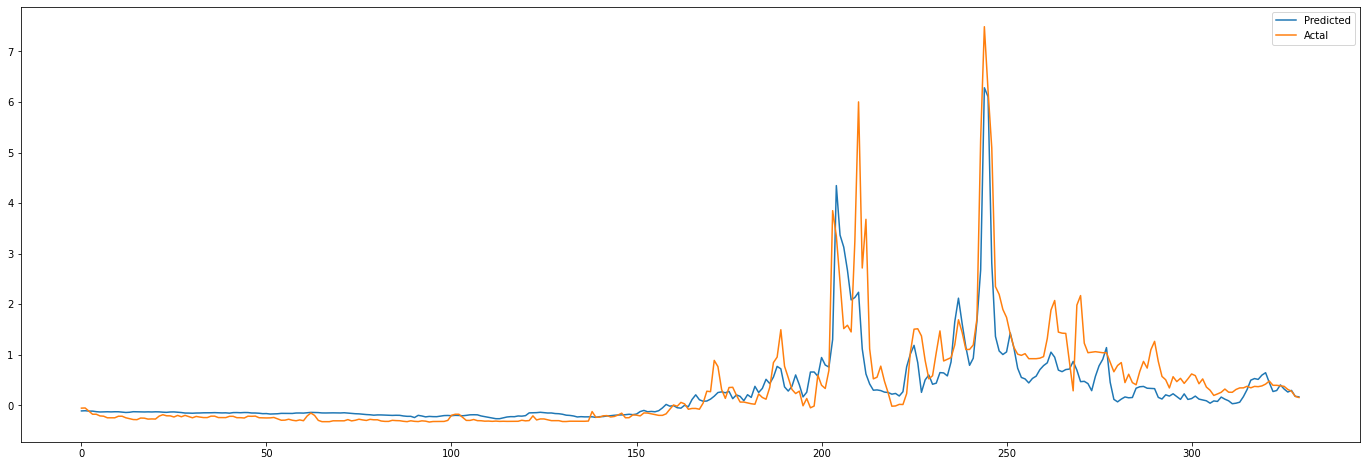

In [30]:
y_actual_inflow, y_pred_inflow = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        yb = yb.to(device).view(-1)

        y_hat = model(xb).view(-1)

        y_actual_inflow += yb.data.tolist()
        y_pred_inflow += y_hat.cpu().data.tolist()

# y_actual_inflow = rs_inflow.inverse_transform(np.array(y_actual_inflow).reshape(-1, 1)).flatten()
# y_pred_inflow = rs_inflow.inverse_transform(np.array(y_pred_inflow).reshape(-1, 1)).flatten()

plt.figure(figsize=(24,8))
plt.plot(y_pred_inflow, label='Predicted')
plt.plot(y_actual_inflow, label='Actal')
plt.legend()
plt.show()

### Prediction on entire Dataset

In [31]:
def pred(df):
    pred_ds = InflowDataset(df.copy())
    pred_dl = DataLoader(pred_ds, batch_size=len(pred_ds))

    model.eval()
    with torch.no_grad():
        for x, y in pred_dl:
            x = x.to(device)
            y = y.to(device).view(-1)

            y_hat = model(x).view(-1)

    return y_hat.data.cpu().view(-1).numpy()

In [32]:
model_test_df = train_emb_df.append(val_emb_df).sort_index().copy()
# model_test_df['Predicted_Inflow'] = pred(model_test_df)
model_test_df['Predicted_Inflow'] = rs_inflow.inverse_transform(pred(model_test_df).reshape(-1, 1)).flatten()
model_test_df[1191] = rs_inflow.inverse_transform(model_test_df[[1191]]).flatten()
model_test_df.rename(columns={1191: 'INFLOW_CUSECS'}, inplace=True)
model_test_df[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,INFLOW_CUSECS,Predicted_Inflow
2011-01-01,0.0,0.0,2.0,-1.196,-1.273038,-2.739437,-0.453571,-0.163701,-0.819840,-0.358491,-0.995111,-0.116022,-1.076700,0.083333,0.083333,0.250000,0.458333,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.584,-1.607509,-2.288732,-0.508929,...,0.0,0.0,0.0,0.0,0.0,-0.980,-0.931741,-1.105634,-0.423214,-0.295374,-0.059863,-0.547170,-0.269329,-0.116022,-0.174695,0.416667,0.333333,0.208333,0.00,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2029.0,1902.733643
2011-01-02,0.0,1.0,2.0,-1.584,-1.607509,-2.288732,-0.508929,-0.042705,-0.606043,-0.283019,-0.824007,-0.116022,-0.232582,0.166667,0.500000,0.166667,0.166667,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.860,-1.798635,-2.788732,-0.675000,...,0.0,0.0,0.0,0.0,0.0,-0.836,-0.846416,-0.933099,-0.801786,0.060498,-0.292474,0.371069,-0.676143,-0.116022,0.139549,0.458333,0.500000,0.041667,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3084.0,1833.359009
2011-01-03,0.0,2.0,2.0,-1.860,-1.798635,-2.788732,-0.675000,0.120996,-0.270810,-0.213836,-0.946525,-0.116022,-0.198057,0.375000,0.375000,0.083333,0.125000,0.041667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.476,-1.436860,-1.859155,-0.628571,...,0.0,0.0,0.0,0.0,0.0,-0.968,-0.996587,-1.281690,-0.635714,0.120996,-0.444128,0.484277,-0.764516,-0.116022,0.214596,0.458333,0.541667,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2776.0,1753.242676
2011-01-04,0.0,3.0,2.0,-1.476,-1.436860,-1.859155,-0.628571,0.074733,-0.247434,-0.157233,-0.909898,-0.116022,-0.763076,0.291667,0.083333,0.041667,0.333333,0.250000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.136,-1.116041,-1.894366,-0.389286,...,0.0,0.0,0.0,0.0,0.0,-1.092,-1.068259,-1.380282,-0.860714,0.000000,-0.180730,0.402516,-0.927422,-0.116022,0.472194,0.000000,1.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2311.0,1808.378174
2011-01-05,0.0,4.0,2.0,-1.136,-1.116041,-1.894366,-0.389286,0.032028,-0.275941,-0.094340,-0.910199,-0.116022,-1.136035,0.041667,0.000000,0.333333,0.458333,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.136,-1.133106,-1.855634,-0.417857,...,0.0,0.0,0.0,0.0,0.0,-1.120,-1.163823,-1.883803,-0.721429,0.000000,-0.629989,0.327044,-1.022413,-0.116022,0.146578,0.291667,0.541667,0.166667,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1847.0,1647.478516
2011-01-06,0.0,5.0,2.0,-1.136,-1.133106,-1.855634,-0.417857,0.135231,-0.370582,-0.081761,-0.930581,-0.116022,-0.565847,0.291667,0.208333,0.125000,0.250000,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.184,-1.197952,-1.595070,-0.635714,...,0.0,0.0,0.0,0.0,0.0,-1.012,-1.040956,-2.003521,-0.467857,-0.145907,-0.579818,-0.062893,-0.538207,-0.116022,-1.186893,0.041667,0.000000,0.375000,0.50,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2156.0,1451.285889
2011-01-07,0.0,6.0,2.0,-1.184,-1.197952,-1.595070,-0.635714,0.313167,-0.480046,0.163522,-0.910199,0.031308,-0.048170,0.208333,0.333333,0.208333,0.083333,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.016,-0.965870,-1.330986,-0.800000,...,0.0,0.0,0.0,0.0,0.0,-0.756,-0.812287,-1.978873,-0.230357,-0.622776,-0.586659,-0.339623,-0.635379,-0.116022,-0.193715,0.416667,0.291667,0.208333,0.00,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [33]:
model_test_df.reset_index(inplace=True)
model_test_df['YEAR'] = model_test_df['index'].astype(str).str[:4].astype(int)
model_test_df['MONTH'] = model_test_df['index'].astype(str).str[5:7].astype(int)
model_test_df['DATE'] = model_test_df['index'].astype(str).str[8:].astype(int)
model_test_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,INFLOW_CUSECS,Predicted_Inflow,YEAR,MONTH,DATE
0,2011-01-01,0.0,0.0,2.0,-1.196,-1.273038,-2.739437,-0.453571,-0.163701,-0.819840,-0.358491,-0.995111,-0.116022,-1.076700,0.083333,0.083333,0.250000,0.458333,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.584,-1.607509,-2.288732,...,0.0,0.0,-0.980,-0.931741,-1.105634,-0.423214,-0.295374,-0.059863,-0.547170,-0.269329,-0.116022,-0.174695,0.416667,0.333333,0.208333,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2029.0,1902.733643,2011,1,1
1,2011-01-02,0.0,1.0,2.0,-1.584,-1.607509,-2.288732,-0.508929,-0.042705,-0.606043,-0.283019,-0.824007,-0.116022,-0.232582,0.166667,0.500000,0.166667,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.860,-1.798635,-2.788732,...,0.0,0.0,-0.836,-0.846416,-0.933099,-0.801786,0.060498,-0.292474,0.371069,-0.676143,-0.116022,0.139549,0.458333,0.500000,0.041667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3084.0,1833.359009,2011,1,2
2,2011-01-03,0.0,2.0,2.0,-1.860,-1.798635,-2.788732,-0.675000,0.120996,-0.270810,-0.213836,-0.946525,-0.116022,-0.198057,0.375000,0.375000,0.083333,0.125000,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.476,-1.436860,-1.859155,...,0.0,0.0,-0.968,-0.996587,-1.281690,-0.635714,0.120996,-0.444128,0.484277,-0.764516,-0.116022,0.214596,0.458333,0.541667,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2776.0,1753.242676,2011,1,3
3,2011-01-04,0.0,3.0,2.0,-1.476,-1.436860,-1.859155,-0.628571,0.074733,-0.247434,-0.157233,-0.909898,-0.116022,-0.763076,0.291667,0.083333,0.041667,0.333333,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.136,-1.116041,-1.894366,...,0.0,0.0,-1.092,-1.068259,-1.380282,-0.860714,0.000000,-0.180730,0.402516,-0.927422,-0.116022,0.472194,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2311.0,1808.378174,2011,1,4
4,2011-01-05,0.0,4.0,2.0,-1.136,-1.116041,-1.894366,-0.389286,0.032028,-0.275941,-0.094340,-0.910199,-0.116022,-1.136035,0.041667,0.000000,0.333333,0.458333,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.136,-1.133106,-1.855634,...,0.0,0.0,-1.120,-1.163823,-1.883803,-0.721429,0.000000,-0.629989,0.327044,-1.022413,-0.116022,0.146578,0.291667,0.541667,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1847.0,1647.478516,2011,1,5


In [34]:
avg_daily_pred_inflow = model_test_df.groupby(['MONTH', 'DATE'])['Predicted_Inflow'].mean().values
avg_daily_actual_inflow = model_test_df.groupby(['MONTH', 'DATE'])['INFLOW_CUSECS'].mean().values

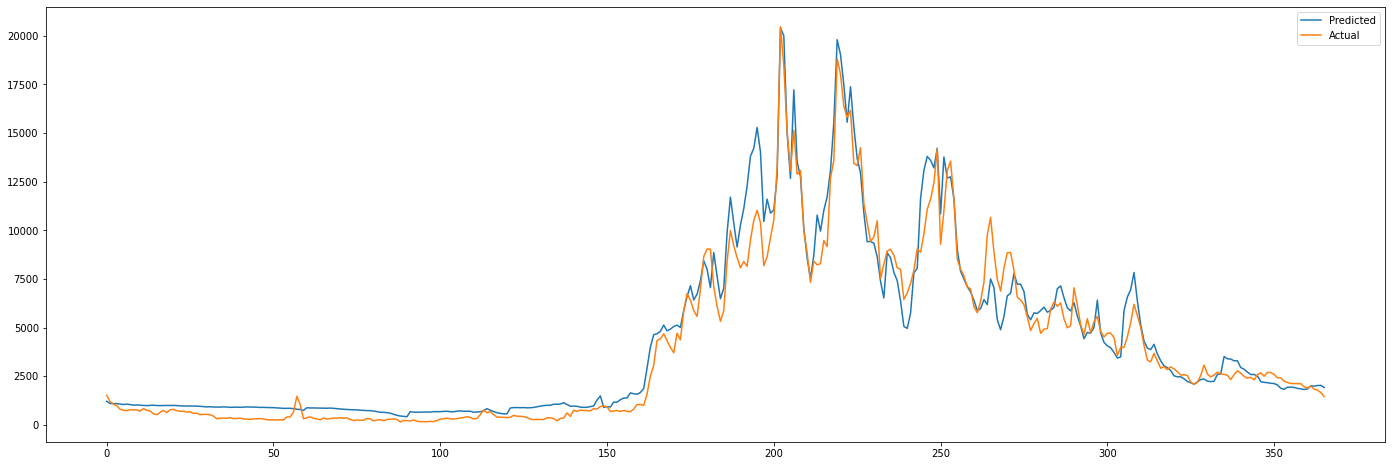

In [35]:
plt.figure(figsize=(24, 8))
plt.plot(avg_daily_pred_inflow, label='Predicted')
plt.plot(avg_daily_actual_inflow, label='Actual')
plt.legend()
# ax2.plot(avg_daily_actual_rainfall, label='Actual')
plt.show()

In [36]:
model_test_df.sort_values(by=['YEAR', 'MONTH', 'DATE'], inplace=True)

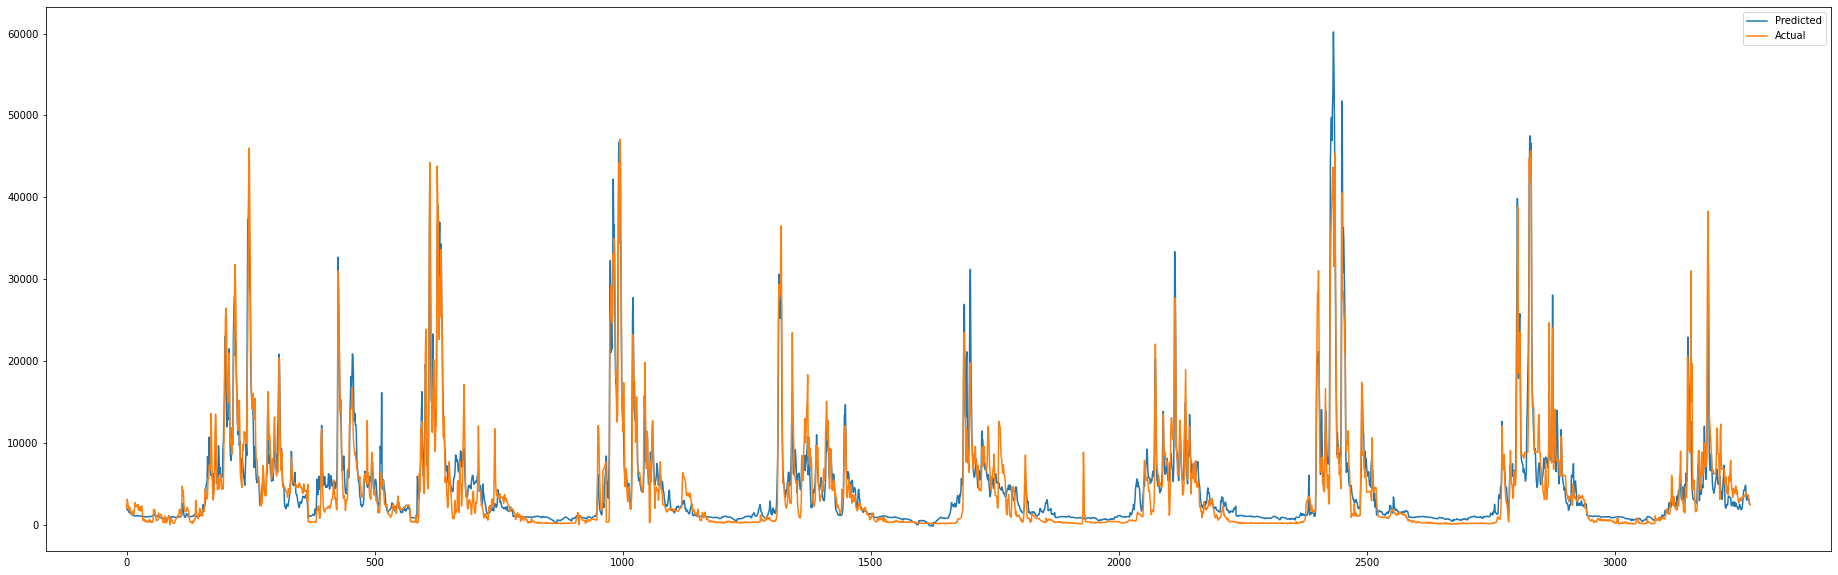

In [37]:
plt.figure(figsize=(32, 10))
plt.plot(model_test_df['Predicted_Inflow'], label='Predicted')
plt.plot(model_test_df['INFLOW_CUSECS'], label='Actual')
plt.legend()
plt.show()

In [38]:
train_data_with_pred = model_test_df[model_test_df['YEAR'] < 2020]
val_data_with_pred = model_test_df[model_test_df['YEAR'] == 2020]
train_data_with_pred.shape, val_data_with_pred.shape

((2944, 1197), (330, 1197))

In [39]:
((train_data_with_pred['INFLOW_CUSECS'] - train_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5

2346.163803537114

In [40]:
((val_data_with_pred['INFLOW_CUSECS'] - val_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5

2494.6565623442716

In [41]:
torch.save(model.state_dict(), 'inflow_weather_mlp_checkpoint_2346_2494_loss.pth')

In [11]:
import pickle
with open('encoders/month_le.pkl', 'wb') as f:
    pickle.dump(month_le, f)

with open('encoders/season_le.pkl', 'wb') as f:
    pickle.dump(season_le, f)

with open('encoders/date_le.pkl', 'wb') as f:
    pickle.dump(date_le, f)

In [12]:
with open('encoders/rs_inflow.pkl', 'wb') as f:
    pickle.dump(rs_inflow, f)

with open('encoders/rs_temp.pkl', 'wb') as f:
    pickle.dump(rs_temp, f)

with open('encoders/rs_feels_like.pkl', 'wb') as f:
    pickle.dump(rs_feels_like, f)

with open('encoders/rs_temp_min.pkl', 'wb') as f:
    pickle.dump(rs_temp_min, f)

with open('encoders/rs_temp_max.pkl', 'wb') as f:
    pickle.dump(rs_temp_max, f)

with open('encoders/rs_pressure.pkl', 'wb') as f:
    pickle.dump(rs_pressure, f)

with open('encoders/rs_humidity.pkl', 'wb') as f:
    pickle.dump(rs_humidity, f)

with open('encoders/rs_wind_speed.pkl', 'wb') as f:
    pickle.dump(rs_wind_speed, f)

with open('encoders/rs_wind_deg.pkl', 'wb') as f:
    pickle.dump(rs_wind_deg, f)

with open('encoders/rs_rain.pkl', 'wb') as f:
    pickle.dump(rs_rain, f)

with open('encoders/rs_clouds_all.pkl', 'wb') as f:
    pickle.dump(rs_clouds_all, f)